##                                                                  CS 559 Hwk 8

  ### Xiaohan Liu                             659692941                                        Nov 14 2017

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.spatial.distance import euclidean
from scipy.interpolate import RectBivariateSpline

#### Q1.
(100pts) In this computer project, we will design an SVM. You may use an existing library for solving the
quadratic optimization problem that is associated with the SVM. For example, the free software Octave has
such a command named \quadprog" to solve such problems. Other than that, you cannot use any existing
machine learning/SVM library. As usual, please include the computer codes in your report.

(a) Draw 100 points x1; ... ; x100 independently and uniformly at random on [0,1]$^2$. These will be our input patterns.

In [2]:
np.random.seed(21)
X = np.random.uniform(0,1,size=200).reshape((2,100))
# ith column of X is X_i

![ ](b.jpg)

In [3]:
ctgy = np.ones(100)
for i in range(X.shape[1]):
    if (X[1,i] >= 0.2 * np.sin(10*X[0,i])+0.3) and ((X[1,i]-0.8)**2 + (X[0,i]-0.5)**2 >= 0.15**2):
            ctgy[i] = -1
t = np.arange(0,1,0.002)
yt = 0.2* np.sin(10*t) +0.3
X = np.vstack((X,ctgy))
C1 = X[:,X[2,:] ==1][0:2,:]
CN1 = X[:,X[2,:] ==-1][0:2,:]

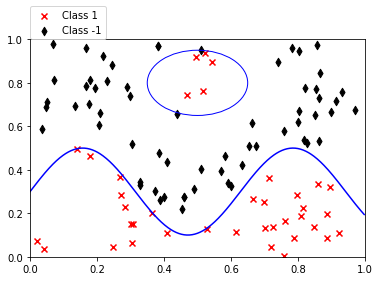

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.add_patch(Circle((0.5,0.8), 0.15, color = 'b', fill = False))
ax.plot(t,yt,color = 'b')
pt1 = plt.scatter(x = C1[0,:], y = C1[1,:],c ='r', marker = 'x')
pt2 = plt.scatter(x = CN1[0,:], y = CN1[1,:],c ='k', marker = 'd')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend([pt1,pt2],('Class 1', 'Class -1'), loc = (0,1))
plt.show()

![](c1.png)
![](c2.png)

I picked the Gaussian Kernel:$K(x,x') = exp(-\frac{||x-x'||^2}{2})$

In [5]:
# Get the desired output
D = X[2,:]
# Define the Kernel function
def Kernel(x, y, p = 10):
    x = np.array(x)
    y = np.array(y)
    return (x.T @ y +1) ** p
# Compute the Kernel matrix for all 100 data points as K1
K1 = np.zeros(100*100).reshape(100,100)
for i in range(100):
    for j in range(100):
        K1[i,j] = Kernel(X[0:2,i],X[0:2,j])

In [6]:
# Use Scipy.optimize.minimize to perform the quadratic programing
from scipy.optimize import minimize
def dual_form (x):
    s = (x * D) @ K1 @ (x * D).T 
    return -(np.sum(x)-0.5*s)
def dual_form_d(x):
    return -(np.ones(100) - x.T @ np.diag(D)@ K1 @ np.diag(D))
cons = ({'type': 'eq',
         'fun' : lambda x: np.sum(x * D)},
        {'type': 'ineq',
         'fun' : lambda x: x})
res = minimize(dual_form,np.zeros(100), jac = dual_form_d,
                   constraints=cons, method='SLSQP', options={'disp': True, 'maxiter':1000})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -141.62325484498467
            Iterations: 45
            Function evaluations: 65
            Gradient evaluations: 45


#### Get the optimized result as the alpha 

In [7]:
# Get the optimized alpha 
alpha = np.round(res.x,7) 
X = np.vstack((X,alpha))
alpha

array([  -0.       ,    0.       ,    0.       ,   -0.       ,
          3.9738284,   -0.       ,    0.       ,    0.       ,
          0.       ,   -0.       ,    0.       ,   -0.       ,
         -0.       ,    0.       ,    0.       ,    0.       ,
          0.       ,   -0.       ,    0.       ,    0.       ,
         -0.       ,    5.499514 ,    0.       ,    0.       ,
         -0.       ,   -0.       ,    0.       ,   -0.       ,
          0.       ,   -0.       ,  130.9371398,   -0.       ,
         -0.       ,   -0.       ,    0.       ,   -0.       ,
          0.       ,  106.3127009,   -0.       ,   -0.       ,
         -0.       ,   -0.       ,   -0.       ,    0.       ,
          0.       ,    0.       ,   -0.       ,   -0.       ,
          0.       ,    0.       ,   -0.       ,    0.       ,
         -0.       ,    0.       ,    0.       ,    0.       ,
         -0.       ,   -0.       ,    0.       ,   -0.       ,
          0.       ,   -0.       ,   -0.       ,   -0. 

#### Get the supporting vectors

In [8]:
# Get the supporting vectors
sv = X[:,X[3,:]>0]
n_sv = sv.shape[1]
sv_temp = pd.DataFrame(sv)
sv_temp

,0,1,2,3,4,5,6,7,8
0,0.205923,0.713360,0.327213,0.267522,0.467601,0.864086,0.365112,0.511137,0.035103
1,0.604845,0.363309,0.330211,0.365868,0.743765,0.533436,0.202257,0.951309,0.588882
2,-1.000000,1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000
3,3.973828,5.499514,130.937140,106.312701,3.917756,1.242600,25.893410,0.710218,4.759595


#### Get the optimized bias $\theta$

In [9]:
theta = list()
for j in range(n_sv):
    temp  = 0
    for i in range(n_sv):
            temp += sv[3,i] * sv[2,i] * Kernel(sv[0:2,i],sv[0:2,j])
    theta.append(sv[2,j] - temp)
theta0 = np.mean(theta)
round(theta0, 7)

15.1503876

#### Now, with the optimized bias calculated, we could start to draw the decision boundary and the two margins. 

In [10]:
# Define a discriminant function g(x)
def disc (x):
    x = np.array(x)
    temp = 0
    for i in range(n_sv):
        temp += sv[3,i] * sv[2,i] * Kernel(sv[0:2,i],x)
    return temp + theta0

In [11]:
# mesh out the decision boundaries
epsilon = 5e-2
H0x1 = list()
H0x2 = list()
Hpx1 = list()
Hpx2 = list()
Hnx1 = list()
Hnx2 = list()
#lamb = np.outer(np.arange(0,1,0.001),np.arange(0,1,0.001))
for x1 in np.arange(0,1,0.001):
    for x2 in np.arange(0,1,0.001):
        x = (x1,x2)
        temp = disc(x)
        if np.abs(temp) < epsilon:
            H0x1.append(x1)
            H0x2.append(x2)
        elif np.abs(temp-1) < epsilon:
            Hpx1.append(x1)
            Hpx2.append(x2)
        elif np.abs(temp+1) < epsilon:
            Hnx1.append(x1)
            Hnx2.append(x2)

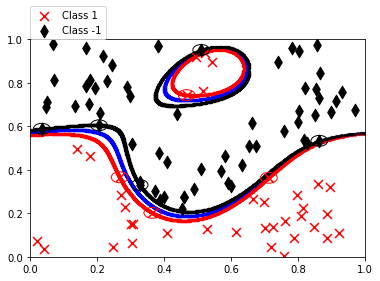

In [12]:
# seperate support vectors by class
svp = sv[:,sv[2,:] ==1.]
svn = sv[:,sv[2,:] ==-1.]
# start ploting
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for i in range(svp.shape[1]):
    ax.add_patch(Circle((svp[0,i],svp[1,i]), 0.025, color = 'r', fill = False))
for i in range(svn.shape[1]):
    ax.add_patch(Circle((svn[0,i],svn[1,i]), 0.025, color = 'k', fill = False))
ptH0 = plt.scatter(H0x1,H0x2, c = 'b', s = 5, alpha = 0.5)
ptHp = plt.scatter(Hpx1,Hpx2, c = 'r', s = 5, alpha = 0.5)
ptHn = plt.scatter(Hnx1,Hnx2, c = 'k', s = 5, alpha = 0.5)
pt1 = plt.scatter(x = C1[0,:], y = C1[1,:],c ='r', marker = 'x', s=80)
pt2 = plt.scatter(x = CN1[0,:], y = CN1[1,:],c ='k', marker = 'd', s=80)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend([pt1,pt2],('Class 1', 'Class -1'), loc = (0.,1.))
plt.show()

In [13]:
# List of support vectors on the class 1
svp_temp = pd.DataFrame(svp)
a = svp_temp.loc[(0,1,3),]
a.rename(index={0: 'x1', 1: 'x2', 3:'alpha'})

,0,1,2,3
x1,0.713360,0.267522,0.467601,0.365112
x2,0.363309,0.365868,0.743765,0.202257
alpha,5.499514,106.312701,3.917756,25.893410


In [19]:
# List of support vectors on the class -1
svn_temp = pd.DataFrame(svn)
a = svn_temp.loc[(0,1,3),]
a.rename(index={0: 'x1', 1: 'x2', 3:'alpha'})

,0,1,2,3,4
x1,0.205923,0.327213,0.864086,0.511137,0.035103
x2,0.604845,0.330211,0.533436,0.951309,0.588882
alpha,3.973828,130.937140,1.242600,0.710218,4.759595
